Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Confusion matrix, without normalization
[[0 0 2 1 0 1 1 0 0 0]
 [0 0 2 0 0 0 2 0 0 1]
 [1 2 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 3 2 0 0]
 [1 0 0 0 0 2 0 1 0 1]
 [0 0 0 0 0 0 1 1 0 3]
 [1 0 0 0 0 4 0 0 0 0]
 [1 0 0 0 0 1 3 0 0 0]
 [0 0 0 0 0 3 0 0 1 1]
 [3 0 0 0 0 1 1 0 0 0]]


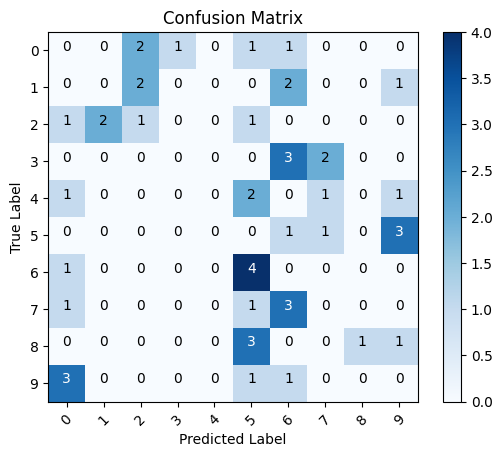

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import GlobalAveragePooling2D
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


path = r'C:\Users\hp\Downloads\data\Sign-Language-Digits-Dataset'
os.chdir(path)
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

# for i in range(0, 10):
#     shutil.move(f'{i}', 'train')
#     os.mkdir(f'valid/{i}')
#     os.mkdir(f'test/{i}')

#     valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
#     for j in valid_samples:
#         shutil.move(f'train/{i}/{j}', f'valid/{i}')

#     test_samples = random.sample(os.listdir(f'train/{i}'), 5)
#     for k in test_samples:
#         shutil.move(f'train/{i}/{k}', f'test/{i}/')

os.chdir('../..')

train_path = 'data/Sign-Language-Digits-Dataset/train'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'
test_path = 'data/Sign-Language-Digits-Dataset/test'


train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)


assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

# modify model
mobile = tf.keras.applications.MobileNetV2()

# Summary of the model architecture
# mobile.summary()

# def count_params(model):
#     trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
#     non_trainable_params = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
#     return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}




x = mobile.layers[-1].output
output = Dense(units=10, activation='softmax')(x)


model = Model(inputs=mobile.input, outputs=output)

for layer in model.layers[:-23]:
    layer.trainable = False

# model.summary()




model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)


# Assuming you have defined test_batches and model elsewhere in your script
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
test_batches.class_indices


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",  # Add the missing comma here
             color="white" if cm[i, j] > thresh else "black")


plt.ylabel('True Label')
plt.xlabel('Predicted Label')



cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
